# Motion Classification
Created 2021.02.21 by Kevin Ta

In [1]:
# Import relevant modules
import os
import glob
import time
from datetime import datetime
from scipy import signal

import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
COUNT_ZERO = False

TERRAINS = ['Asphalt', 'Carpet', 'Concrete', 'Gravel', 'Grass', 'Linoleum', 'Sidewalk']
TERRAINS_R1 = ['No Motion','Indoor', 'Asphalt-Sidewalk', 'Grass', 'Gravel']
TERRAINS_R2 = ['No Motion','Indoor', 'Outdoor']

TEST_SET = [('Jamie', 'Sidewalk','Straight')]

PERSON = 'Everyone'

SOURCE = '0512-Time-Relabelled2'

nonzero = 0

current_path = os.getcwd()

y_true = np.array([])
y_pred = np.array([])
timeDiffs = np.array([0])

for dataset in TEST_SET:

    data = pd.read_csv(os.path.join('2021-Results', SOURCE, '200ms-6050-{}-{}-{}.csv'.format(dataset[1], dataset[2], dataset[0])))
    
    y_pred_temp = data['RF Time'].to_numpy(dtype=np.int8)
    y_true_temp = data['True Label'].to_numpy(dtype=np.int8)
    timeDiffs_temp = np.diff(data['Time'].to_numpy())
    nonzero += len(y_true_temp) - len(y_pred_temp)
    
    y_true = np.append(y_true, y_true_temp[0:len(y_pred_temp)])
    y_pred = np.append(y_pred, y_pred_temp)
    timeDiffs = np.append(timeDiffs, timeDiffs_temp[0:len(y_pred_temp)])
    
    print(y_true.shape)
    print(y_pred.shape)
    print(timeDiffs.shape)

if COUNT_ZERO:
    y_true = np.append(y_true, np.zeros(nonzero))
    y_pred = np.append(y_pred, np.zeros(nonzero))

(4908,)
(4908,)
(4908,)


(4908,)


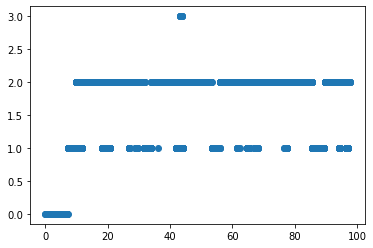

In [3]:
times = np.cumsum(timeDiffs)
print(times.shape)

#f_ind = (y_pred!=0).argmax(axis=0)

#y_pred = np.trim_zeros(y_pred)
#y_true = y_true[f_ind:f_ind+len(y_pred)]
#times = times[f_ind:f_ind+len(y_pred)]

plt.scatter(times, y_pred)

In [4]:
motionData = pd.read_csv(os.path.join('set_power', 'Middle_{}Power{}{}_Module6050.csv'.format(dataset[1], dataset[2], dataset[0])))

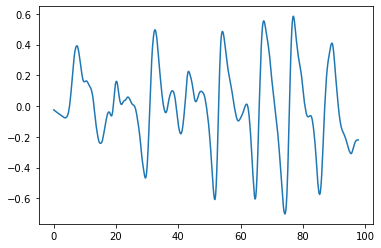

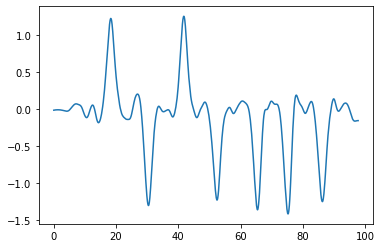

In [5]:
# Get normalized frequencies
w_low = 2 * 0.2 / 300

# Get Butterworth filter parameters
sos = signal.butter(N=2, Wn=w_low, btype='low', output='sos')

xAccel = motionData['ACCELEROMETER X (m/s²)']
zGyro = motionData['GYROSCOPE Z (rad/s)']

xAccel_filt = signal.sosfiltfilt(sos, xAccel)
zGyro_filt = signal.sosfiltfilt(sos, zGyro)

plt.figure()
plt.plot(motionData['Time since start in ms '], xAccel_filt)

plt.figure()
plt.plot(motionData['Time since start in ms '], zGyro_filt)

Text(0.5, 1.0, 'Classification Accuracy & Gyroscope Motion')

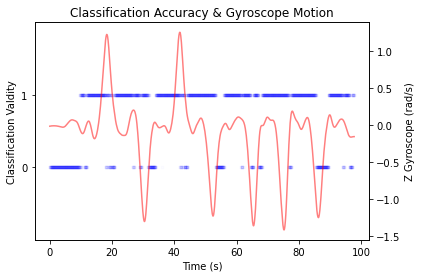

In [6]:
fig,ax1 = plt.subplots()
ax2 =ax1.twinx()
ax1.scatter(times, y_pred==y_true, c='b', marker='.', alpha=0.01)
ax2.plot(motionData['Time since start in ms '], zGyro_filt, 'r', alpha = 0.5)
ax1.set_xlabel('Time (s)')
ax1.set_yticks([0,1])
ax1.set_ylim([-1,2])
ax2.set_ylabel('Z Gyroscope (rad/s)')
ax1.set_ylabel('Classification Valdity')
ax1.set_title('Classification Accuracy & Gyroscope Motion')

4908
355


Text(0.5, 1.0, 'Classification vs. Gyroscopic Motion')

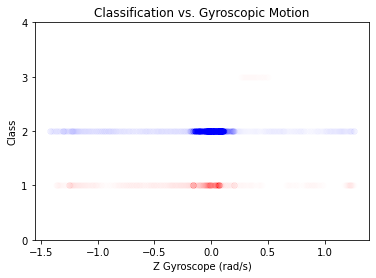

In [7]:
zGyro_interp = np.interp(times, motionData['Time since start in ms '], zGyro_filt)

correct_ind = y_pred==y_true
incorrect_ind = y_pred!=y_true

in_ind = y_pred==1
sa_ind = y_pred==2
gs_ind = y_pred==3
gv_ind = y_pred==4

f_ind = (y_pred!=0).argmax(axis=0)
l_ind = len(y_pred) - (np.flip(y_pred)!=0).argmax(axis=0)

print(l_ind)
print(f_ind)
incorrect_ind[0:f_ind] = False
incorrect_ind[l_ind:] = False

plt.figure()
plt.scatter(zGyro_interp[correct_ind], y_pred[correct_ind], c='b', marker='o', alpha=0.005)
plt.scatter(zGyro_interp[incorrect_ind], y_pred[incorrect_ind], c='r', marker='o', alpha=0.005)
plt.xlabel('Z Gyroscope (rad/s)')
plt.ylabel('Class')
plt.yticks([0,1,2,3,4])
plt.title('Classification vs. Gyroscopic Motion')

(4908,)
[ 919 1199 1528 1920 2100 2636 3046 3289 3782 4336]


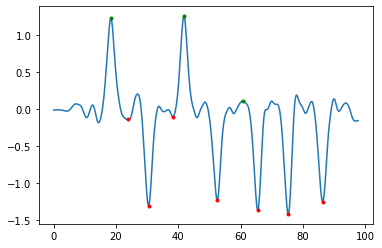

In [8]:
print(zGyro_interp.shape)
m = 1000
n =400
minGyro = signal.argrelmin(zGyro_interp[m:-200], order = 200)[0] + m
maxGyro = signal.argrelmax(zGyro_interp[n:-1500], order = 400)[0] + n

extGyro = np.sort(np.concatenate((minGyro, maxGyro)))

print(extGyro)

plt.plot(times, zGyro_interp)
plt.plot(times[minGyro], zGyro_interp[minGyro], 'r.')
plt.plot(times[maxGyro], zGyro_interp[maxGyro], 'g.')

Text(0.5, 1.0, 'Location Errors for Sidewalk Straight Jamie')

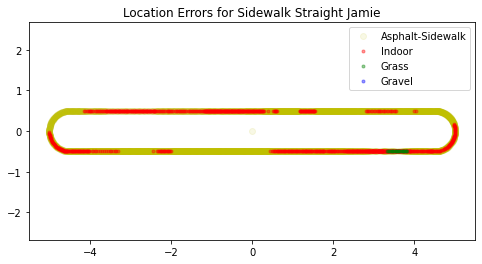

In [15]:
x = np.zeros(len(zGyro_interp))
y = np.zeros(len(zGyro_interp))

t = 0
dist = 9 + np.pi*0.5
qcirc = np.pi*0.25 / dist
stra = 9 / dist

for i in range(len(extGyro)):
    if i == 0:
        diffTime = (times[extGyro[i]])
        while times[t] < qcirc*diffTime:
            x[t] = - 4.5 - 0.5 * np.cos( 0.5 * np.pi * (times[t] - 0) / (qcirc*diffTime) )
            y[t] =         0.5 * np.sin( 0.5 * np.pi * (times[t] - 0) / (qcirc*diffTime) )
            t = t + 1
        while times[t] < (qcirc+stra)*diffTime:
            x[t] = - 4.5 + 9 * (times[t] - (qcirc)*diffTime) / (stra*diffTime) 
            y[t] =         0.5
            t = t + 1
        while times[t] < (2*qcirc+stra)*diffTime:
            x[t] =  4.5 + 0.5 * np.sin( 0.5 * np.pi * (times[t] - (stra+qcirc)*diffTime) / (qcirc*diffTime) )
            y[t] =        0.5 * np.cos( 0.5 * np.pi * (times[t] - (stra+qcirc)*diffTime) / (qcirc*diffTime) )
            t = t + 1
    elif i%2 == 1:
        diffTime = (times[extGyro[i]] - times[extGyro[i-1]])
        prev_time = times[extGyro[i-1]]
        while times[t] < prev_time + qcirc*diffTime:
            x[t] = + 4.5 + 0.5 * np.cos( 0.5 * np.pi * (times[t] - prev_time) / (qcirc*diffTime) )
            y[t] =       - 0.5 * np.sin( 0.5 * np.pi * (times[t] - prev_time) / (qcirc*diffTime) )
            t = t + 1
        while times[t] < prev_time + (qcirc+stra)*diffTime:
            x[t] =   4.5 - 9 * (times[t] - prev_time - (qcirc)*diffTime) / (stra*diffTime) 
            y[t] =       - 0.5
            t = t + 1
        while times[t] < prev_time + diffTime:
            x[t] = - 4.5 - 0.5 * np.sin( 0.5 * np.pi * (times[t] - prev_time - (stra+qcirc)*diffTime) / (qcirc*diffTime) )
            y[t] =       - 0.5 * np.cos( 0.5 * np.pi * (times[t] - prev_time - (stra+qcirc)*diffTime) / (qcirc*diffTime) )
            t = t + 1
    elif i%2 == 0:
        diffTime = (times[extGyro[i]] - times[extGyro[i-1]])
        prev_time = times[extGyro[i-1]]
        while times[t] < prev_time + qcirc*diffTime:
            x[t] = - 4.5 - 0.5 * np.cos( 0.5 * np.pi * (times[t] - prev_time) / (qcirc*diffTime) )
            y[t] =       + 0.5 * np.sin( 0.5 * np.pi * (times[t] - prev_time) / (qcirc*diffTime) )
            t = t + 1
        while times[t] < prev_time + (qcirc+stra)*diffTime:
            x[t] = - 4.5 + 9 * (times[t] - prev_time - (qcirc)*diffTime) / (stra*diffTime) 
            y[t] =       + 0.5
            t = t + 1
        while times[t] < prev_time + (2*qcirc+stra)*diffTime:
            x[t] =   4.5 + 0.5 * np.sin( 0.5 * np.pi * (times[t] - prev_time - (stra+qcirc)*diffTime) / (qcirc*diffTime) )
            y[t] =       + 0.5 * np.cos( 0.5 * np.pi * (times[t] - prev_time - (stra+qcirc)*diffTime) / (qcirc*diffTime) )
            t = t + 1
    #print(times[t])

    
diffTime = (times[-1] - times[extGyro[-1]])
prev_time = times[extGyro[-1]]
while times[t] < prev_time + qcirc*diffTime:
    x[t] = + 4.5 + 0.5 * np.cos( 0.5 * np.pi * (times[t] - prev_time) / (qcirc*diffTime) )
    y[t] =       - 0.5 * np.sin( 0.5 * np.pi * (times[t] - prev_time) / (qcirc*diffTime) )
    t = t + 1
while times[t] < prev_time + (qcirc+stra)*diffTime:
    x[t] =   4.5 - 9 * (times[t] - prev_time - (qcirc)*diffTime) / (stra*diffTime) 
    y[t] =       - 0.5
    t = t + 1
while times[t] < prev_time + diffTime:
    x[t] = - 4.5 - 0.5 * np.sin( 0.5 * np.pi * (times[t] - prev_time - (stra+qcirc)*diffTime) / (qcirc*diffTime) )
    y[t] =       - 0.5 * np.cos( 0.5 * np.pi * (times[t] - prev_time - (stra+qcirc)*diffTime) / (qcirc*diffTime) )
    t = t + 1

plt.figure(figsize=(8,4))
plt.plot(x[sa_ind],y[sa_ind], 'yo', alpha = 0.1)
plt.plot(x[in_ind],y[in_ind], 'r.', alpha = 0.4)
plt.plot(x[gs_ind],y[gs_ind], 'g.', alpha = 0.4)
plt.plot(x[gv_ind],y[gv_ind], 'b.', alpha = 0.4)
plt.legend(["Asphalt-Sidewalk", "Indoor", "Grass", "Gravel"])
plt.axis('equal')
plt.title('Location Errors for {} {} {}'.format(dataset[1], dataset[2], dataset[0]))